# "Automatic differentiation - d2l.ai Exercises - Part 5"
> "The fifth notebook in the series solving exercises from d2l.ai, this blog tries to test and understand the working of the autodiff functionality in tensorflow"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [d2l.ai-exercises, deep-learning, tensorflow]
- hide: false

In [1]:
#collapse
import tensorflow as tf

In [ ]:
#collapse
x = tf.range(4, dtype=tf.float32)
# allocate memory
x = tf.Variable(x)

## Why is the second derivative much more expensive to compute than the first derivative?

As we have learnt in our previous lessons about the chain rule and its usage to differentiate composite functions, applying the chain rule for a second time quickly adds up the number of times that we need to differentiate. Let's take an example,

Suppose that functions  $y=f(u)$  and  $u=g(x)$  are both differentiable, then the chain rule states that,

$$\frac{dy}{dx} = \frac {dy}{du} * \frac {du}{dx}$$

let's assume $a=\frac {dy}{du}$ and $b = \frac {du}{dx}$

so a second derivative of that would be (using product rule here),

$$\frac{d^2y}{dx^2} =  a*\frac{db}{dx} + b * \frac {da}{dx} $$

We can see that the number of differentiations have doubled for this simple composite function. This is a simple reason for why the calculation is expensive for the second derivative.

## After running the function for backpropagation, immediately run it again and see what happens.

Let's check value of x

In [ ]:
x

<tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([0., 1., 2., 3.], dtype=float32)>

### 1st time

In [ ]:
with tf.GradientTape() as t:
    y = x * x
t.gradient(y, x)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 2., 4., 6.], dtype=float32)>

### 2nd time

In [ ]:
t.gradient(y, x)

RuntimeError: ignored

I get the above error when I try to run the backward propagation two times, looking at the documentation of `tf.GradientTape` it is specified that

> By default, the resources held by a GradientTape are released as soon as GradientTape.gradient() method is called. To compute multiple gradients over the same computation, create a persistent gradient tape. This allows multiple calls to the gradient() method as resources are released when the tape object is garbage collected.

## [Question 3](http://d2l.ai/chapter_preliminaries/autograd.html#exercises)
**TLDR**: Try using a vector/matrix in the function used to demonstrate gradient calculation on a control flow.

Let's bring that function used in the [lesson](http://d2l.ai/chapter_preliminaries/autograd.html#computing-the-gradient-of-python-control-flow)

In [ ]:
def f(a):
    b = a * 2
    while tf.norm(b) < 1000:
        b = b * 2
    if tf.reduce_sum(b) > 0:
        c = b
    else:
        c = 100 * b
    return c

In the lesson they have used single value random variable, the question asks us to use a vector or matrix in its place.

Let's use the following random vector with shape `(1,2)`

In [ ]:
#collapse
a = tf.Variable(tf.random.normal(shape=(1, 2)))
a

<tf.Variable 'Variable:0' shape=(1, 2) dtype=float32, numpy=array([[0.02355854, 0.7092207 ]], dtype=float32)>

The differentiation

In [ ]:
#collapse
with tf.GradientTape() as t:
    d = f(a)
d_grad = t.gradient(d, a)
d_grad

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[2048., 2048.]], dtype=float32)>

We can try using a bigger matrix now.

In [ ]:
#collapse
a = tf.Variable(tf.random.normal(shape=(5, 3, 2)))
a

<tf.Variable 'Variable:0' shape=(5, 3, 2) dtype=float32, numpy=
array([[[ 1.075387  ,  0.3135932 ],
        [-0.9573184 ,  0.06560528],
        [-0.18362595, -0.53352755]],

       [[ 0.48579827,  0.7452166 ],
        [ 0.08363861, -1.1838139 ],
        [-0.23465118, -0.7641606 ]],

       [[-1.6045334 , -0.50408304],
        [-0.82722497, -0.26551095],
        [ 0.5110664 ,  0.68872666]],

       [[ 0.9107071 ,  1.2259225 ],
        [ 0.43528086, -0.36280373],
        [-1.7287321 , -0.54161024]],

       [[ 0.01597405, -0.01879804],
        [ 1.75937   ,  1.2245483 ],
        [ 0.04912755,  0.9361492 ]]], dtype=float32)>

In [ ]:
#collapse
with tf.GradientTape() as t:
    d = f(a)
d_grad = t.gradient(d, a)
d_grad

<tf.Tensor: shape=(5, 3, 2), dtype=float32, numpy=
array([[[256., 256.],
        [256., 256.],
        [256., 256.]],

       [[256., 256.],
        [256., 256.],
        [256., 256.]],

       [[256., 256.],
        [256., 256.],
        [256., 256.]],

       [[256., 256.],
        [256., 256.],
        [256., 256.]],

       [[256., 256.],
        [256., 256.],
        [256., 256.]]], dtype=float32)>

So when we differentiate a single value, the resultant gradient vector is similar in shape, as in the cases of the higher dimensional vectors/matrices.

I did not get what the question was trying to test the reader on, I read the [discussion](https://discuss.d2l.ai/t/auto-differentiation/200/4), A person said to use `tf.hessians` to a related question. Let's see why

Let's take a look at the matrix we have

In [ ]:
#collapse
a = tf.Variable(tf.random.normal(shape=()), trainable=True)
a

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-1.1861123>

The following is the suggested way to calculate a [hessian](https://www.tensorflow.org/guide/advanced_autodiff#example_hessian) based vector product

In [ ]:
# let's use hessians
with tf.GradientTape() as t2:
    with tf.GradientTape() as t1:
        d1 = f(a)
    diff_1 = t1.gradient(d1, a)
diff_2 = t2.gradient(diff_1, a)
diff_2

In [ ]:
diff_1, diff_2

(<tf.Tensor: shape=(), dtype=float32, numpy=102400.0>, None)

The following is modified based on [this](https://www.tensorflow.org/guide/advanced_autodiff#example_hessian) to see what happens.

In [ ]:
# let's use jacobian
with tf.GradientTape() as t4:
    t4.watch(a)
    with tf.GradientTape() as t3:
        t3.watch(a)
        d = f(a)
    dif = t3.gradient(d, a)
j_diff = t4.jacobian(dif, a)

In [ ]:
dif, j_diff

(<tf.Tensor: shape=(), dtype=float32, numpy=102400.0>, None)

Both the methods return the same result for the small vector, where the second order derivative is turning into None, I am not sure why..., thinking about the question asked, since $f(a)$ is no longer scalar, the resultant gradient is also a vector/matrix. So I am again not sure of the suggestion given.

## Redesign an example of finding the gradient of the control flow. Run and analyze the result.

The example given in the lesson was a little complex, I will use a simple control flow, to see if we can calculate the gradient with autodiff.

### Control flow

#### Test with exponentiation

Let's start with a simple transformation, We all know the gradient of an exponential function is the same.

In [8]:
def f(x):
    return tf.math.exp(x)

Let's take a single value

In [9]:
#collapse
x = tf.Variable(tf.random.normal(shape=()), trainable=True)
x

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5236874>

In [10]:
with tf.GradientTape() as t:
    y = f(x)

dy_dx = t.gradient(y, x)

In [11]:
y == dy_dx

<tf.Tensor: shape=(), dtype=bool, numpy=True>

#### Test with a random function

So now we can try performing some transformations on the value.

$$y \rightarrow f(x) \rightarrow \left\{\left(
    \eqalign{
        \sin{x}, if \sum{x}_n/n > 0.5\\
        2 * \cos{x}, else\\
    } 
  \right) \right\}$$

In [36]:
def f(x):
    if tf.math.reduce_sum(x) > 0.5:
        x = tf.math.sin(x)
    else:
        x = 2 * tf.math.cos(x)
    return x

In [37]:
#collapse
x = tf.Variable(tf.random.normal(shape=(20, 1)), trainable=True)
x

<tf.Variable 'Variable:0' shape=(20, 1) dtype=float32, numpy=
array([[ 0.7322539 ],
       [-1.2769327 ],
       [ 0.85455877],
       [-0.96424586],
       [-0.7693011 ],
       [ 0.33113363],
       [-1.3973997 ],
       [-2.1953282 ],
       [ 1.4873    ],
       [-0.7533999 ],
       [-0.58519673],
       [-0.94799626],
       [ 0.67873853],
       [ 0.34689212],
       [ 0.4139984 ],
       [ 0.5342669 ],
       [-0.06651524],
       [-0.19935435],
       [-0.3597326 ],
       [-0.24857213]], dtype=float32)>

The differentiation

In [38]:
#collapse_show
with tf.GradientTape() as t:
    y = f(x)

dy_dx = t.gradient(y, x)
dy_dx

<tf.Tensor: shape=(20, 1), dtype=float32, numpy=
array([[-1.337095  ],
       [ 1.9142638 ],
       [-1.5085627 ],
       [ 1.6432385 ],
       [ 1.3912666 ],
       [-0.6502306 ],
       [ 1.9700089 ],
       [ 1.6224738 ],
       [-1.9930325 ],
       [ 1.368245  ],
       [ 1.1047268 ],
       [ 1.6244967 ],
       [-1.2556233 ],
       [-0.6799534 ],
       [-0.8045463 ],
       [-1.0184205 ],
       [ 0.13293241],
       [ 0.396073  ],
       [ 0.7040479 ],
       [ 0.49204046]], dtype=float32)>

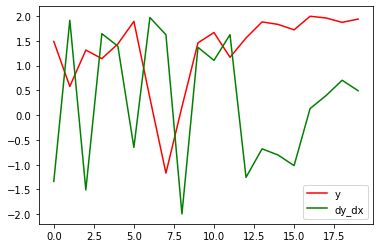

In [44]:
#collapse
x_axis = tf.range(0, 20, 1)
plt.plot(x_axis, tf.reshape(f(x), [-1]).numpy(), color='r', label='y')
plt.plot(x_axis, tf.reshape(dy_dx, [-1]).numpy(), color='g', label='dy_dx')
plt.legend(loc='lower right')
plt.show()

The graph seems to be validating differentiation, since we can see the green line following the red line

## Let  $f(x)=sin(x)$ . Plot  $f(x)$  and  $\frac {df(x)}{dx}$ , where the latter is computed without exploiting that  $f′(x)=cos(x)$.

Let's setup the required variables

In [ ]:
#collapse_show
# sine function
f = tf.math.sin

x = tf.Variable(tf.range(-10, 10, 0.1))
with tf.GradientTape() as t:
    y = f(x)

# the gradient of sin(x) is cos(x)
dy_dx = t.gradient(y, x)

In [39]:
#hide
import matplotlib.pyplot as plt

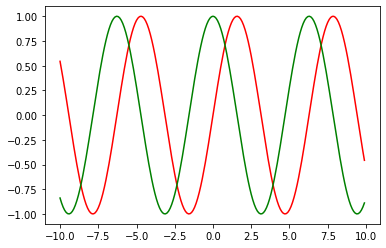

In [ ]:
#collapse
plt.figure(1)
x_axis = tf.range(-10, 10, 0.1)
plt.plot(x_axis, f(x).numpy(), color='r')
plt.plot(x_axis, dy_dx.numpy(), color='g')
plt.show()